In [3]:
import sys
import os
import pandas as pd
sys.path.append(os.path.abspath('../Scripts'))


from Model import MLAlgorithms

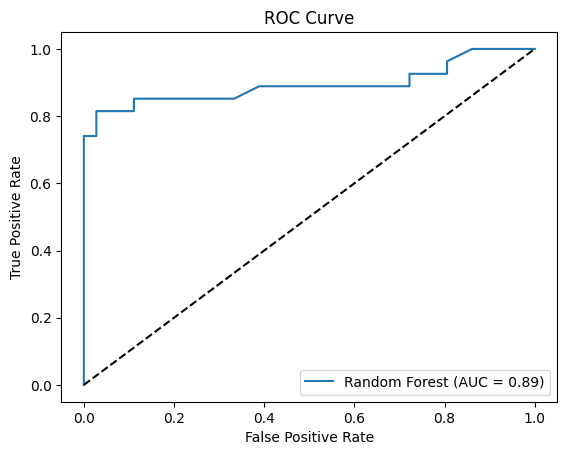

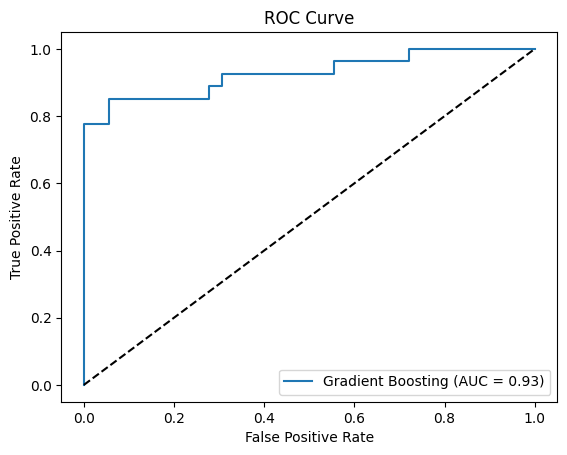

Model Evaluation Results:
               Model  Precision  F1 Score  AUC Score  Accuracy
0      Random Forest   0.851852  0.851852   0.893004  0.873016
1  Gradient Boosting   0.851852  0.851852   0.926955  0.873016


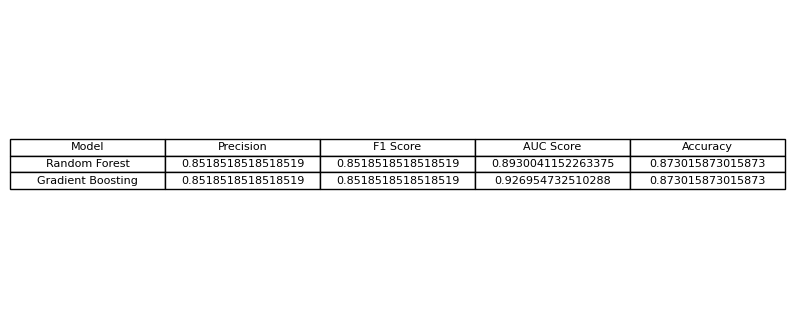

In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Load data
data_path = '../Data/merged_weekly_Dambi Dollo Comprehensive  Specialized  Hospital..csv'
target_column = 'target'  # The column we want to predict

# Assuming you've already loaded the data into `data` (or from file)
data = pd.read_csv(data_path)

# Drop the "Dambi Dollo Comprehensive Specialized Hospital." column
#data.drop(columns=["Dambi Dollo Comprehensive  Specialized  Hospital."], inplace=True)

# Preprocess the data (classification based on median and adding 'target' column)
# You can adapt the code below to add your target column classification logic
# For instance, if target column is created based on the median value of some feature
data['target'] = (data[target_column] > data[target_column].median()).astype(int)

# Now, create the MLAlgorithms class and pass in the preprocessed data
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

class MLAlgorithms:
    def __init__(self, data):
        self.data = data
        # Assuming 'target' is the target column
        self.X = self.data.drop(columns=['target', 'date', 'Dambi Dollo Comprehensive  Specialized  Hospital.'])  # Drop date and target columns
        self.y = self.data['target']  # Adjust this based on your target column name
        self.results = []  # To store the results for the table

    def preprocess_features(self):
        # Convert the 'date' column to numerical features (optional)
        self.data['date'] = pd.to_datetime(self.data['date'], errors='coerce')  # Convert to datetime
        self.data['year'] = self.data['date'].dt.year
        self.data['month'] = self.data['date'].dt.month
        self.data['day'] = self.data['date'].dt.day

        # Now we can add these new features to X if desired
        self.X = self.data.drop(columns=['target', 'date', 'Dambi Dollo Comprehensive  Specialized  Hospital.'])  # Recreate X with new features
        
        # Select numeric columns only for scaling
        numeric_columns = self.X.select_dtypes(include=[float, int]).columns
        self.X = self.X[numeric_columns]

        # Standardize features
        scaler = StandardScaler()
        self.X = scaler.fit_transform(self.X)

    def evaluate_model(self, model, X_test, y_test, y_pred_proba, model_name):
        # Evaluate model
        y_pred = model.predict(X_test)
        
        # Calculate performance metrics
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)  # Accuracy score
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

        # Store the metrics in the results list for the table
        self.results.append({
            'Model': model_name,
            'Precision': precision,
            'F1 Score': f1,
            'AUC Score': auc_score,
            'Accuracy': accuracy
        })

        return auc_score, fpr, tpr

    def plot_roc_curve(self, fpr, tpr, auc_score, model_name):
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    def train_random_forest(self):
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

        # Set up the model and hyperparameters for tuning
        rf = RandomForestClassifier(random_state=42)
        param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
        grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
        
        # Train the model
        grid_search.fit(X_train, y_train)
        
        # Evaluate and plot results
        y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
        auc_score, fpr, tpr = self.evaluate_model(grid_search.best_estimator_, X_test, y_test, y_pred_proba, 'Random Forest')
        self.plot_roc_curve(fpr, tpr, auc_score, 'Random Forest')

    def train_gradient_boosting(self):
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

        # Set up the model and hyperparameters for tuning
        gb = GradientBoostingClassifier(random_state=42)
        param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5]}
        grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
        
        # Train the model
        grid_search.fit(X_train, y_train)
        
        # Evaluate and plot results
        y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
        auc_score, fpr, tpr = self.evaluate_model(grid_search.best_estimator_, X_test, y_test, y_pred_proba, 'Gradient Boosting')
        self.plot_roc_curve(fpr, tpr, auc_score, 'Gradient Boosting')

    def display_results_table(self):
        # Create a DataFrame from the results and display it
        results_df = pd.DataFrame(self.results)
        print("Model Evaluation Results:")
        print(results_df)

        # Optional: You can plot the table using matplotlib
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.axis('tight')
        ax.axis('off')
        ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
        plt.show()

# Create an instance of the MLAlgorithms class
ml_algorithms = MLAlgorithms(data)

# Preprocess features (standardization)
ml_algorithms.preprocess_features()

# Train and evaluate models with hyperparameter tuning and ROC-AUC curves
ml_algorithms.train_random_forest()
ml_algorithms.train_gradient_boosting()

# Display the evaluation results table
ml_algorithms.display_results_table()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

class ModelEvaluator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.models = {
            "Random Forest": RandomForestClassifier(),
            "Gradient Boosting": GradientBoostingClassifier(),
            "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            "SVR": SVR(),
            "MLP": MLPClassifier(max_iter=1000)
        }
        self.cv = StratifiedKFold(n_splits=5)  # 5-fold cross-validation
        self.param_grids = {
            "Random Forest": {
                'n_estimators': [100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False]
            },
            "Gradient Boosting": {
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 4, 5],
                'subsample': [0.8, 0.9, 1.0],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            "XGBoost": {
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 4, 5],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0]
            },
            "SVR": {
                'kernel': ['linear', 'poly', 'rbf'],
                'C': [0.1, 1, 10],
                'epsilon': [0.01, 0.1, 0.2]
            },
            "MLP": {
                'hidden_layer_sizes': [(50,), (100,), (50, 50)],
                'activation': ['relu', 'tanh'],
                'solver': ['adam', 'sgd'],
                'alpha': [0.0001, 0.001],
                'learning_rate': ['constant', 'adaptive']
            }
        }

    def plot_roc(self):
        plt.figure(figsize=(10, 8))  # Set the figure size
        for model_name, model in self.models.items():
            best_model = self._tune_hyperparameters(model_name, model)
            self._plot_model_roc(model_name, best_model)
        
        # Plot the diagonal line (random classifier)
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)

        # Customizing plot for publication quality
        plt.title(f'Mean ROC Curves for All Models', fontsize=16)
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(loc='lower right', fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()

        # Display the plot
        plt.show()

    def _tune_hyperparameters(self, model_name, model):
        """Tune hyperparameters using GridSearchCV"""
        grid_search = GridSearchCV(estimator=model,
                                   param_grid=self.param_grids[model_name],
                                   cv=self.cv,
                                   scoring='roc_auc',
                                   n_jobs=-1,
                                   verbose=1)
        grid_search.fit(self.X, self.y)
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        return grid_search.best_estimator_

    def _plot_model_roc(self, model_name, model):
        fpr_list, tpr_list, auc_list = [], [], []  # Reset lists for each model
        roc_auc_per_fold = []

        # Perform the k-fold cross-validation
        for fold, (train_idx, test_idx) in enumerate(self.cv.split(self.X, self.y)):
            X_train, X_test = self.X.iloc[train_idx], self.X.iloc[test_idx]  # For pandas DataFrame
            y_train, y_test = self.y.iloc[train_idx], self.y.iloc[test_idx]  # For pandas Series
            
            # Fit the model on the training data
            model.fit(X_train, y_train)
            
            # Get prediction probabilities for ROC curve (positive class probability)
            if model_name in ["SVR", "MLP"]:
                y_pred_proba = model.predict(X_test)
                y_pred_proba = (y_pred_proba > 0.5).astype(int)  # Convert to binary for ROC
            else:
                y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            # Calculate ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            
            # Append the ROC curve data and AUC
            fpr_list.append(fpr)
            tpr_list.append(tpr)
            auc_list.append(roc_auc)
            roc_auc_per_fold.append(roc_auc)  # Store AUC for this fold
            
            # Plot ROC curve for the current fold with specific styling
            plt.plot(fpr, tpr, linestyle='-', color='C{}'.format(fold), label=f'{model_name} Fold {fold + 1} (AUC = {roc_auc:.2f})')

        # Calculate the mean ROC curve (average FPR and TPR across all folds)
        mean_fpr = np.linspace(0, 1, 100)  # 100 points for interpolation
        mean_tpr = np.zeros_like(mean_fpr)

        # Interpolate TPR values for each fold at the common FPR values
        for fpr, tpr in zip(fpr_list, tpr_list):
            mean_tpr += np.interp(mean_fpr, fpr, tpr)

        # Average the TPR values
        mean_tpr /= len(fpr_list)

        # Plot the mean ROC curve
        mean_auc = np.mean(roc_auc_per_fold)
        plt.plot(mean_fpr, mean_tpr, linestyle='-', lw=3, label=f'{model_name} Mean ROC (AUC = {mean_auc:.2f})')

        # Print the mean AUC for this model
        print(f'{model_name} Mean AUC across all folds: {mean_auc:.2f}')

# Example usage
# Assuming X (features) and y (target) are defined from your dataset
evaluator = ModelEvaluator(X, y)
evaluator.plot_roc()

NameError: name 'X' is not defined